## Table of Contents
- [Data Loading](#Data-Loading)
- [Data Cleaning and Preprocessing](#Data-Cleaning-and-Preprocessing)
- [Exploratory Data Analysis and Visualizations](#Exploratory-Data-Analysis-and-Visualizations)
- [Predictive Model: Predicting Dropped Connection](#Predictive-Model-Predicting-Dropped-Connection)


In [1]:
# Import libraries and suppress warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')    # Use Agg backend for matplotlib
import matplotlib.pyplot as plt
plt.switch_backend('Agg')   # For cases when only plt is used
%matplotlib inline

import seaborn as sns

# Additional libraries for predictive modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.inspection import permutation_importance

sns.set(style='whitegrid')

In [3]:
# # Data Loading(sirs code)
# try:
#     # Read the CSV file with the proper encoding
#     df = pd.read_csv('5g_network_data.csv',header = 1 encoding='ISO-8859-1')
    
#     # Clean column names (strip extra spaces)
#     df.columns = df.columns.str.strip()
    
#     # Due to encoding issues, sometimes the temperature column may be misnamed, such as "Temperature (Â°C)".
#     # We adjust the column names if necessary.
#     new_columns = {}
#     for col in df.columns:
#         if 'Temperature' in col and '°C' not in col:
#             # Replace mis-encoded characters
#             new_columns[col] = "Temperature (°C)"
#     if new_columns:
#         df.rename(columns=new_columns, inplace=True)

#     print('Data loaded successfully with columns:')
#     print(df.columns.tolist())
# except Exception as e:
#     print(f'Error loading data: {e}')

    # Data Loading(gpt code)
try:
    # Read the CSV file with safe encoding
    df = pd.read_csv('5g_network_data.csv',header = 1, encoding='ISO-8859-1')
    
    # Clean column names
    df.columns = df.columns.str.strip()
    
    # Handle encoding errors in temperature column
    new_columns = {}
    for col in df.columns:
        if 'Temperature' in col and ('°C' not in col or 'Â' in col):
            new_columns[col] = "Temperature (°C)"
    
    if new_columns:
        print(f"Renaming columns due to encoding fix: {new_columns}")
        df.rename(columns=new_columns, inplace=True)

    # Warn if there are unnamed columns
    if any('Unnamed' in col for col in df.columns):
        print("⚠️ Warning: Some columns are unnamed. Check the CSV file format or header.")

    print('Data loaded successfully with columns:')
    print(df.columns.tolist())

except Exception as e:
    print(f'❌ Error loading data: {e}')


Renaming columns due to encoding fix: {'Temperature (Â°C)': 'Temperature (°C)'}
Data loaded successfully with columns:
['Timestamp', 'Location', 'Signal Strength (dBm)', 'Download Speed (Mbps)', 'Upload Speed (Mbps)', 'Latency (ms)', 'Jitter (ms)', 'Network Type', 'Device Model', 'Carrier', 'Band', 'Battery Level (%)', 'Temperature (°C)', 'Connected Duration (min)', 'Handover Count', 'Data Usage (MB)', 'Video Streaming Quality', 'VoNR Enabled', 'Network Congestion Level', 'Ping to Google (ms)', 'Dropped Connection']


In [3]:
print(df.columns.tolist())

['Timestamp', 'Location', 'Signal Strength (dBm)', 'Download Speed (Mbps)', 'Upload Speed (Mbps)', 'Latency (ms)', 'Jitter (ms)', 'Network Type', 'Device Model', 'Carrier', 'Band', 'Battery Level (%)', 'Temperature (°C)', 'Connected Duration (min)', 'Handover Count', 'Data Usage (MB)', 'Video Streaming Quality', 'VoNR Enabled', 'Network Congestion Level', 'Ping to Google (ms)', 'Dropped Connection']


In [4]:
# Data Cleaning and Preprocessing
import datetime

try:
    # Convert Timestamp column to datetime to allow time-based analysis
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
except Exception as e:
    print(f'Error converting Timestamp column to datetime: {e}')

# It is important to check that the conversion is done correctly, as improperly parsed dates can lead to subtle errors in analysis.

# Check for missing values
missing_values = df.isnull().sum()
print('Missing values by column:')
print(missing_values)

# For the purpose of this analysis, drop rows with missing critical values
df.dropna(subset=['Timestamp', 'Download Speed (Mbps)'], inplace=True)


# Ensure numeric columns are correctly typed. We focus on columns that should be numeric.
numeric_cols = [
    'Signal Strength (dBm)', 'Download Speed (Mbps)', 'Upload Speed (Mbps)', 'Latency (ms)',
    'Jitter (ms)', 'Battery Level (%)', 'Temperature (°C)', 'Connected Duration (min)',
    'Handover Count', 'Data Usage (MB)', 'Video Streaming Quality', 'Ping to Google (ms)'
]

# Convert the specified columns to numeric, coercing errors to NaN
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    else:
        # Log a helpful message if column is missing
        print(f'Warning: {col} not found in dataframe columns.')

# Display cleaned dataframe info
df.info()

Missing values by column:
Timestamp                   0
Location                    0
Signal Strength (dBm)       0
Download Speed (Mbps)       0
Upload Speed (Mbps)         0
Latency (ms)                0
Jitter (ms)                 0
Network Type                0
Device Model                0
Carrier                     0
Band                        0
Battery Level (%)           0
Temperature (°C)            0
Connected Duration (min)    0
Handover Count              0
Data Usage (MB)             0
Video Streaming Quality     0
VoNR Enabled                0
Network Congestion Level    0
Ping to Google (ms)         0
Dropped Connection          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Timestamp                 50000 non-null  datetime64[ns]
 1   Location                  50000

Summary statistics for numeric columns:
                           Timestamp  Signal Strength (dBm)  \
count                          50000           50000.000000   
mean   2024-12-05 16:24:00.000000256             -84.837274   
min              2024-06-15 01:49:00            -110.000000   
25%              2024-09-09 21:06:30             -97.400000   
50%              2024-12-05 16:24:00             -84.800000   
75%              2025-03-02 11:41:30             -72.200000   
max              2025-05-28 06:59:00             -60.000000   
std                              NaN              14.477643   

       Download Speed (Mbps)  Upload Speed (Mbps)  Latency (ms)   Jitter (ms)  \
count           50000.000000         50000.000000  50000.000000  50000.000000   
mean              551.181074            84.801756     10.497244      2.560705   
min               100.040000            20.000000      1.000000      0.100000   
25%               324.650000            52.230000      5.700000     

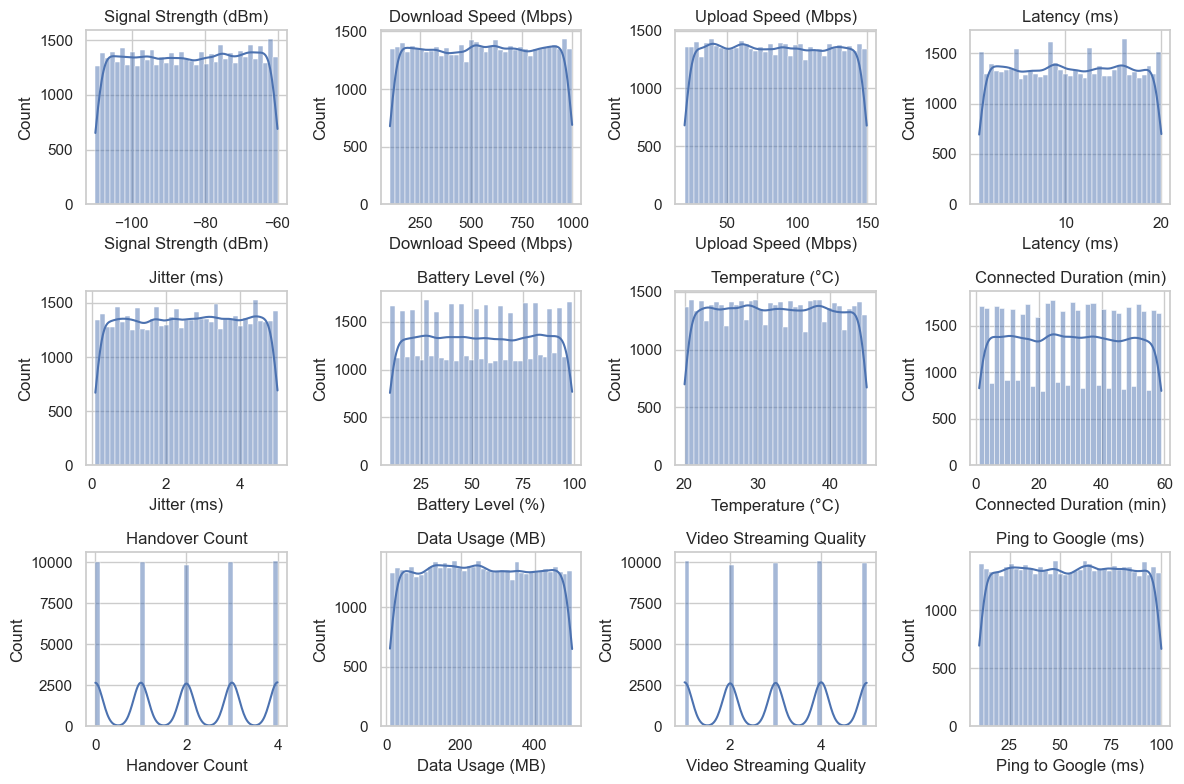

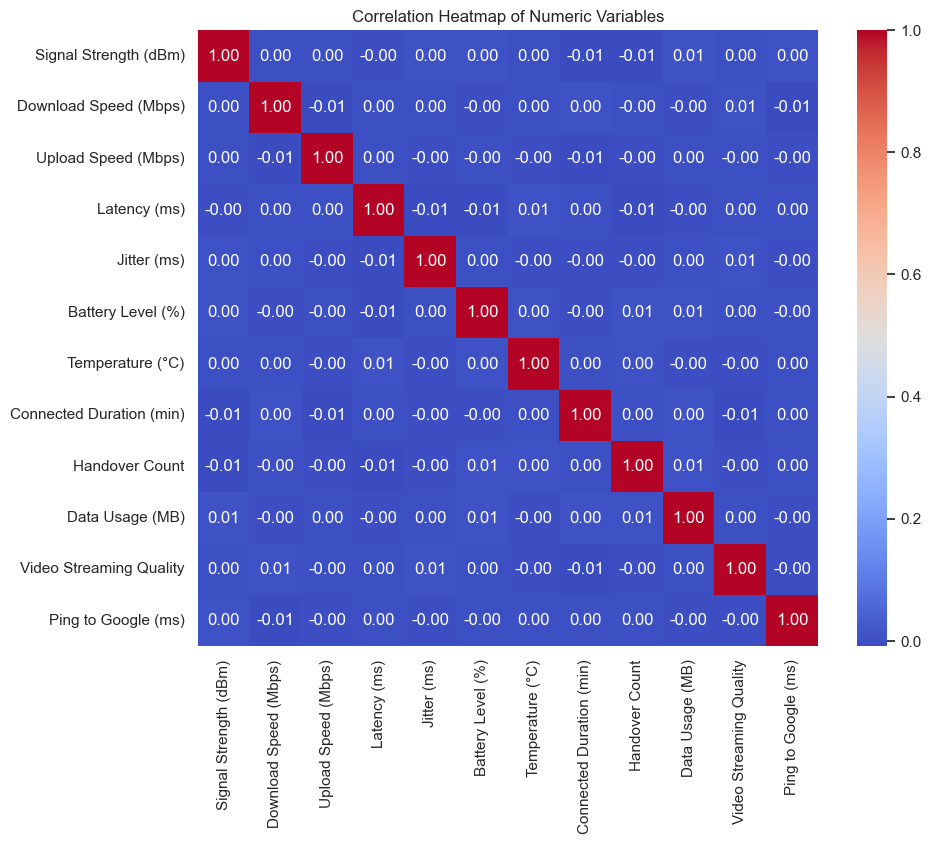

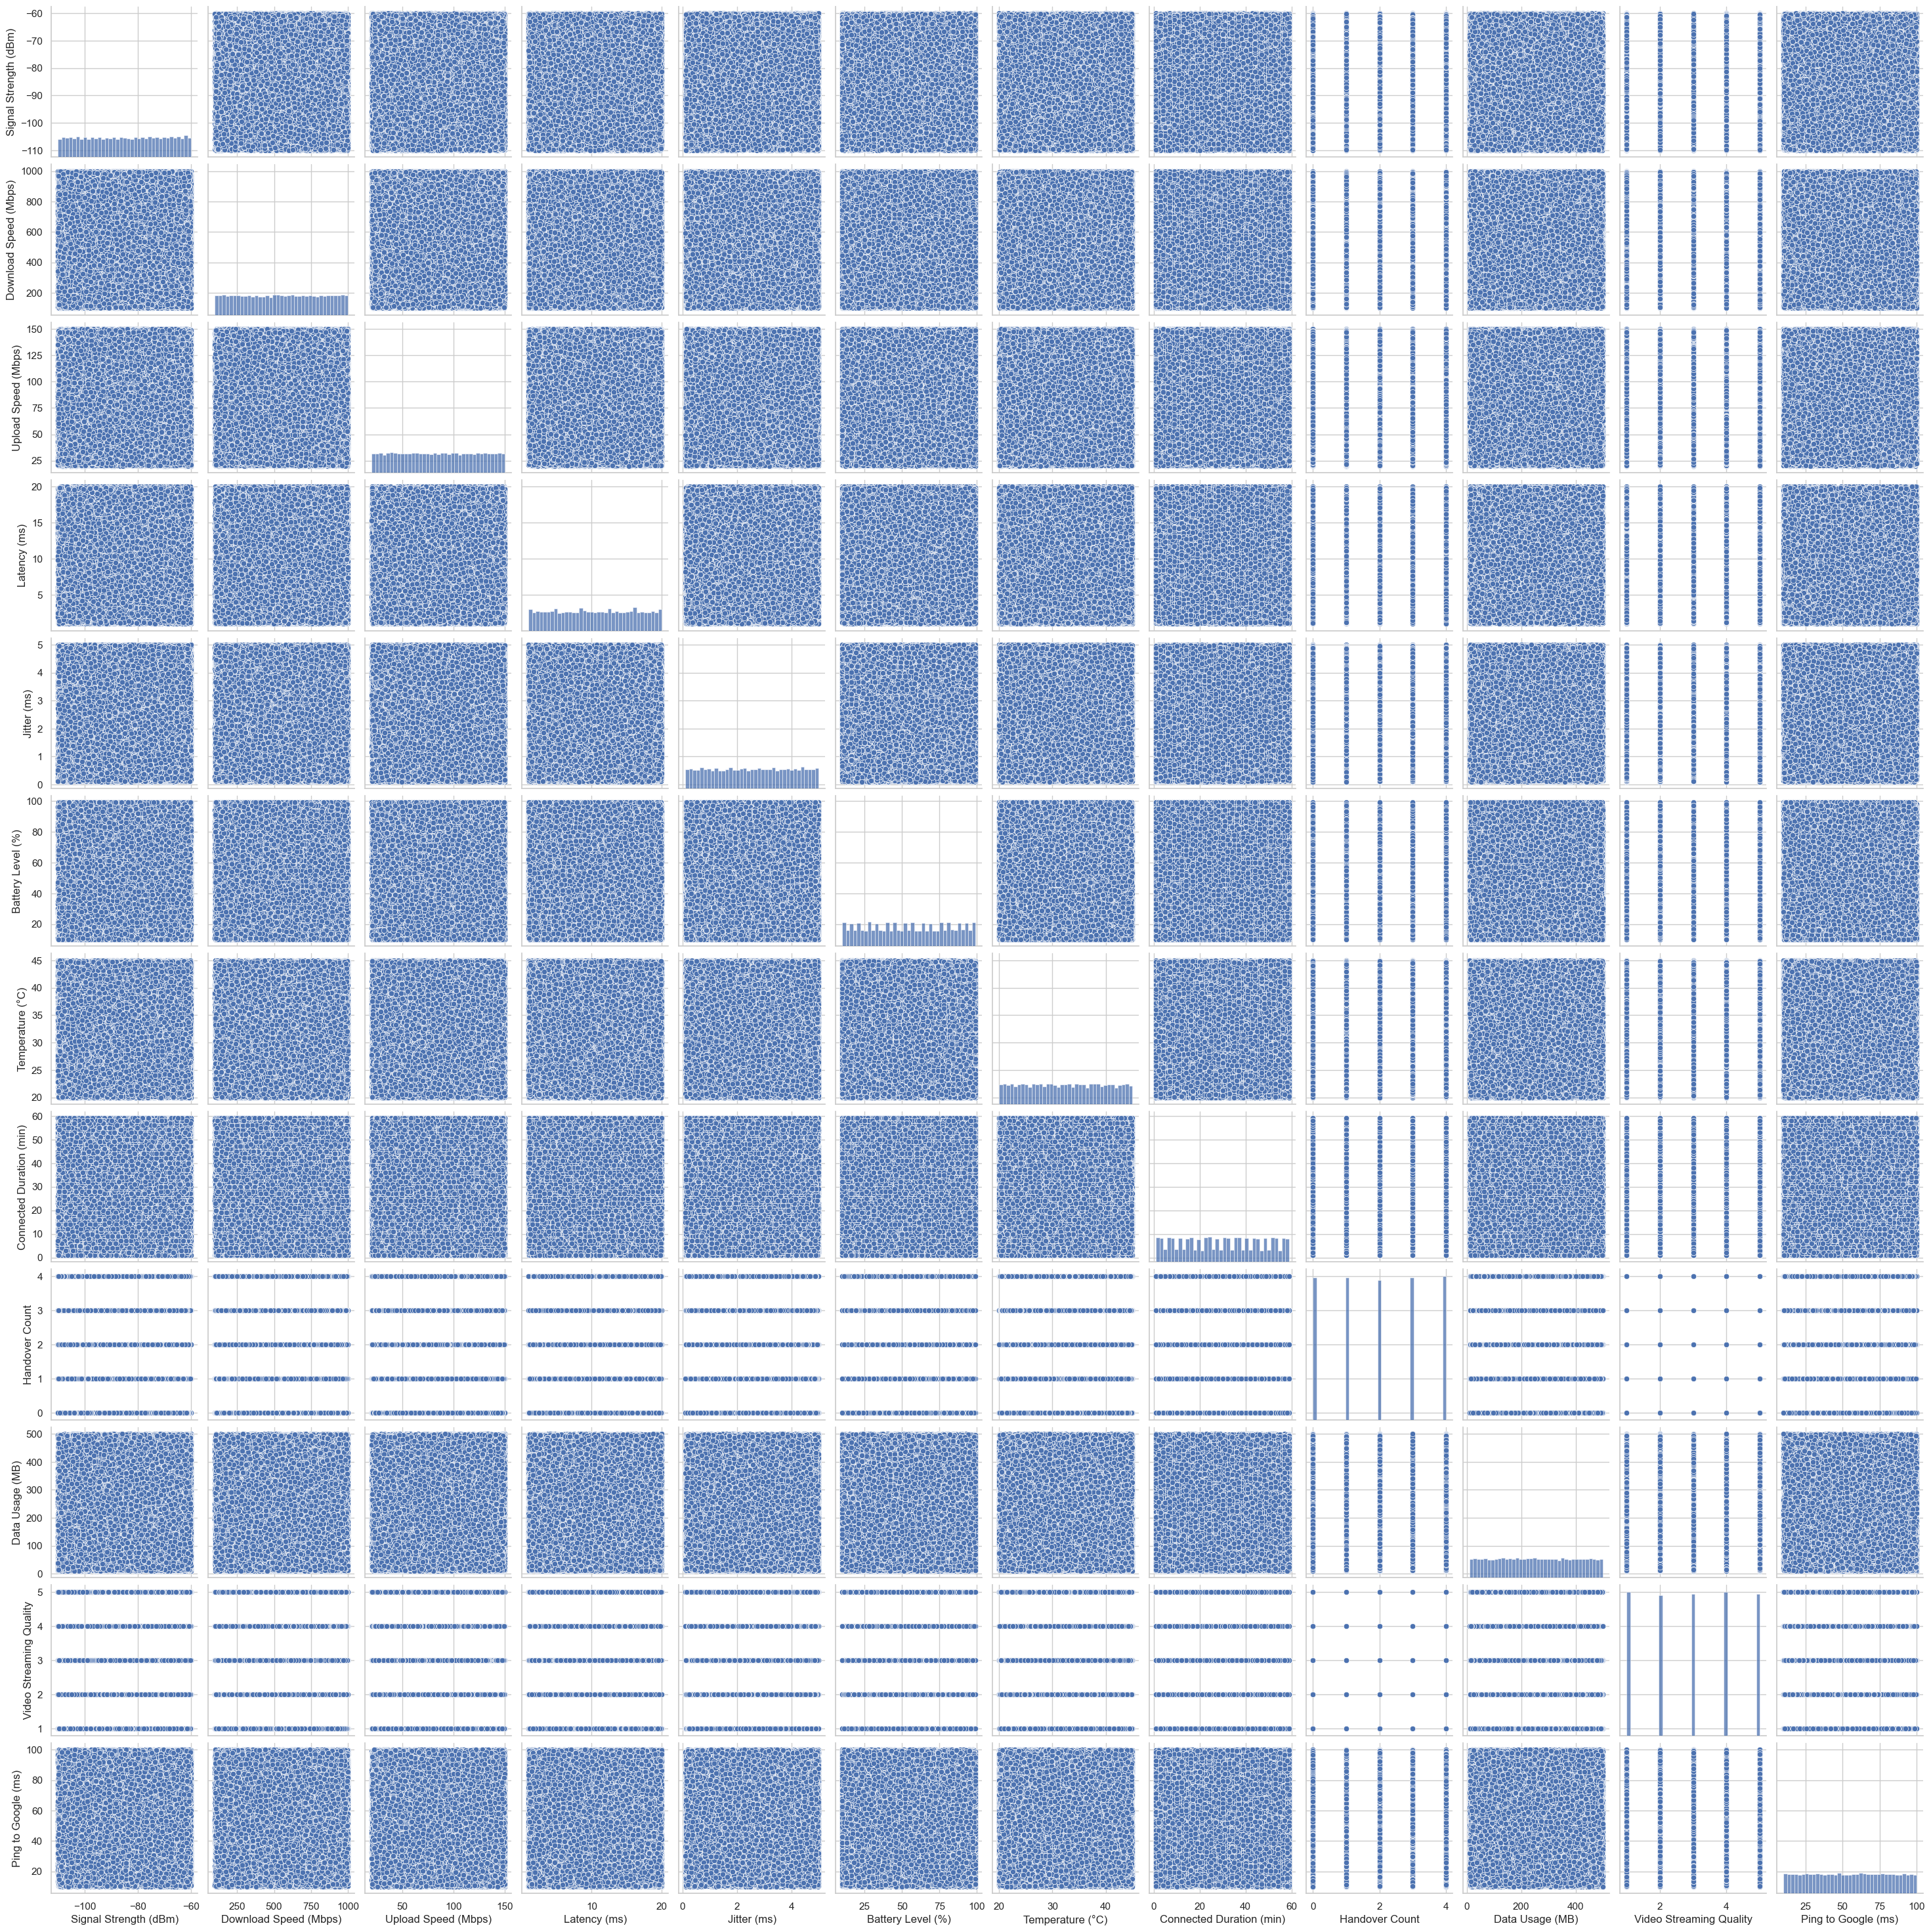

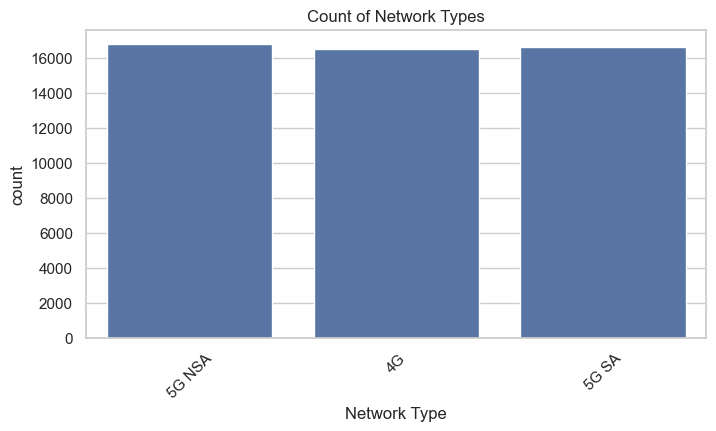

In [5]:
# Exploratory Data Analysis and Visualizations

# Display summary statistics
print('Summary statistics for numeric columns:')
print(df.describe())

# Plot histograms for some key numeric columns
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols):
    if col in df.columns:
        plt.subplot(3, 4, i+1)
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(col)
plt.tight_layout()
plt.show()

# If there are four or more numeric columns, plot a correlation heatmap
numeric_df = df.select_dtypes(include=[np.number])
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(10, 8))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Numeric Variables')
    plt.show()

# Pair Plot for selected numeric columns (if data size permits)
cols_for_pairplot = [col for col in numeric_cols if col in df.columns]
if len(cols_for_pairplot) >= 2:
    sns.pairplot(df[cols_for_pairplot].dropna())
    plt.show()

# Bar plot for the count of Network Types
plt.figure(figsize=(8, 4))
sns.countplot(x='Network Type', data=df)
plt.title('Count of Network Types')
plt.xticks(rotation=45)
plt.show()

Prediction Accuracy: 0.50


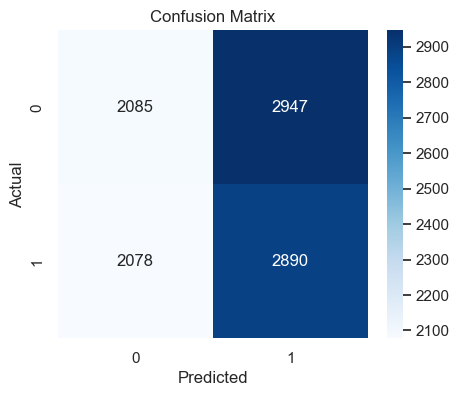

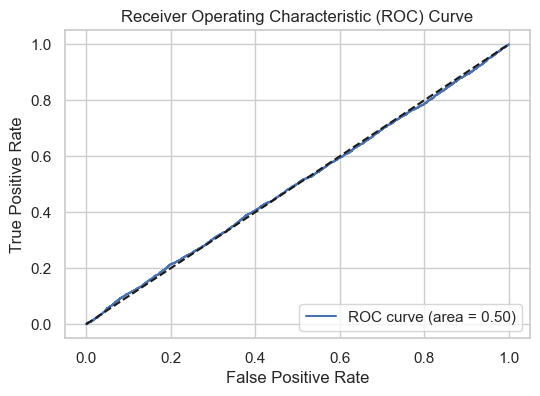

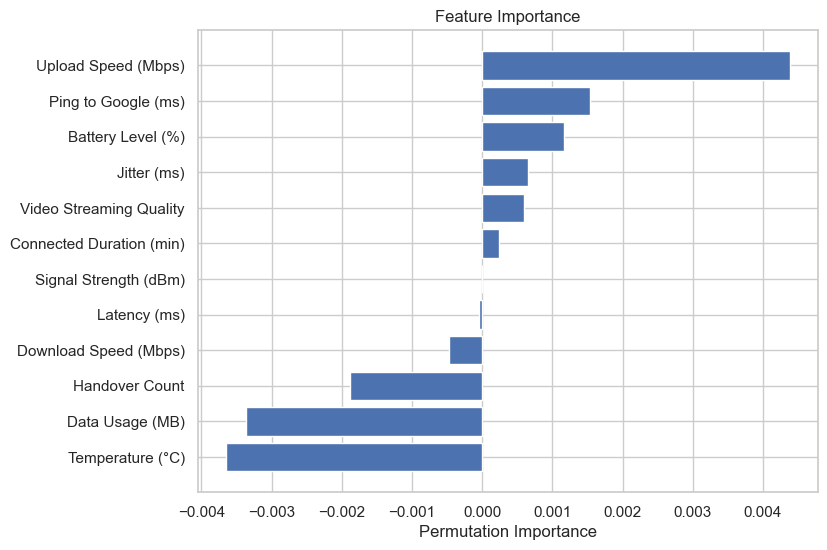

In [7]:
# Predictive Model: Predicting Dropped Connection
# In this section we create a logistic regression model to predict whether a connection is dropped.

from sklearn.preprocessing import StandardScaler

# We'll consider numeric columns and a few categorical variables for this prediction.
predictor_cols = [
    'Signal Strength (dBm)', 'Download Speed (Mbps)', 'Upload Speed (Mbps)',
    'Latency (ms)', 'Jitter (ms)', 'Battery Level (%)', 'Temperature (°C)',
    'Connected Duration (min)', 'Handover Count', 'Data Usage (MB)', 'Video Streaming Quality',
    'Ping to Google (ms)'
]

# Ensure predictors exist in the dataframe
predictor_cols = [col for col in predictor_cols if col in df.columns]

# Drop rows with missing values in the predictor columns or the target column
data_model = df[predictor_cols + ['Dropped Connection']].dropna()

# Convert the target column to integer (0/1) if not already
data_model['Dropped Connection'] = data_model['Dropped Connection'].astype(int)

# Split into training and testing sets
X = data_model[predictor_cols]
y = data_model['Dropped Connection']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = model.predict(X_test_scaled)

# Calculate prediction accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Prediction Accuracy: {accuracy:.2f}')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC Curve
y_prob = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate and display permutation importance as a bar chart
result = permutation_importance(model, X_test_scaled, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(8, 6))
plt.barh(np.array(predictor_cols)[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance')
plt.show()